# Инициализация данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df_path = "BostonHousing.csv"
boston = pd.read_csv(df_path)
print(boston)

        crim    zn  indus  chas    nox     rm   age     dis  rad  tax  \
0    0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296   
1    0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242   
2    0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242   
3    0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222   
4    0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...  ...   
501  0.06263   0.0  11.93     0  0.573  6.593  69.1  2.4786    1  273   
502  0.04527   0.0  11.93     0  0.573  6.120  76.7  2.2875    1  273   
503  0.06076   0.0  11.93     0  0.573  6.976  91.0  2.1675    1  273   
504  0.10959   0.0  11.93     0  0.573  6.794  89.3  2.3889    1  273   
505  0.04741   0.0  11.93     0  0.573  6.030  80.8  2.5050    1  273   

     ptratio       b  lstat  medv  
0       15.3  396.90   4.98  24.0  
1       17.8  396.90   9.14  21.6  
2       17.8  3

# Подготовка датасета

In [2]:
boston.dropna(inplace=True)

X, y = boston.iloc[:, :-1].values, boston.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train_s = StandardScaler().fit_transform(X_train)
X_test_s = StandardScaler().fit_transform(X_test)

# Параметры нейронной сети

In [3]:
nn_params = {'in_features': X.shape[1], 'h1': 16, 'h2': 8, 'out': 1}

# Определение нейронной сети

In [78]:
from torch import nn, optim, FloatTensor, relu, manual_seed


class TorchNN(nn.Module):
    def __init__(self, in_features, h1, h2, out):
        super(TorchNN, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, out)

    def forward(self, x):
        x = relu(self.fc1(x))
        x = relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Оптимизация параметров и построение графиков

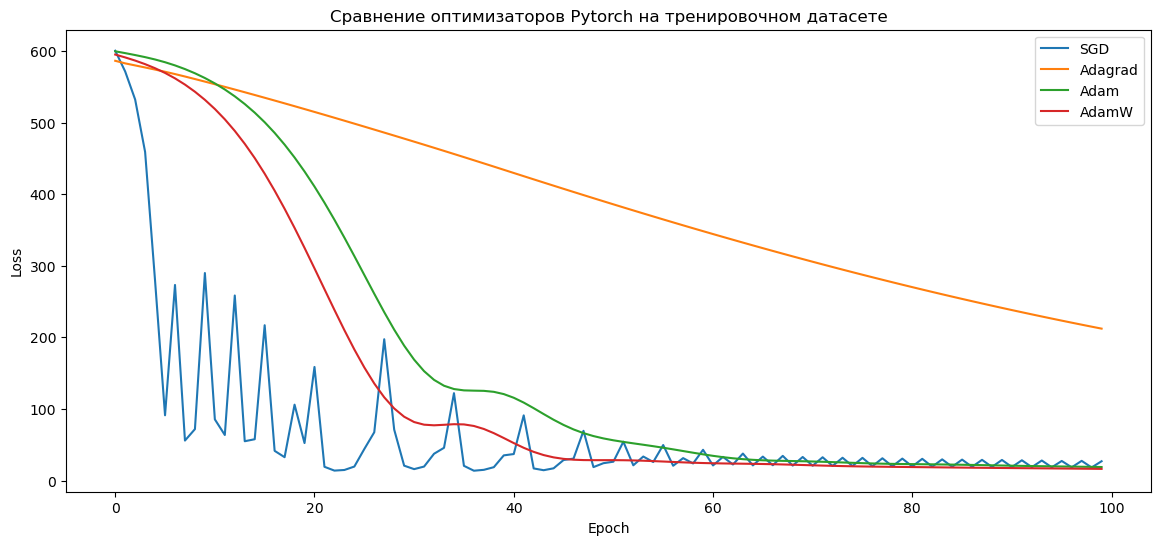

In [85]:
def torch_losses(data, model, optim_cls, optim_params, num_epochs=100):
    losses = []
    X_train, y_train = data
    criterion = nn.MSELoss()
    optimizer = optim_cls(model.parameters(), **optim_params)

    for epoch in range(num_epochs):
        y_pred = model.forward(X_train)
        loss = criterion(y_pred, y_train)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses


manual_seed(2017)
X_train_s_tensor = FloatTensor(X_train_s)
y_train_tensor = FloatTensor(y_train).view(-1, 1)

torch_optimizers = [
    (optim.SGD, 'SGD', {'lr': 0.01}),
    (optim.Adagrad, 'Adagrad', {'lr': 0.01}),
    (optim.Adam, 'Adam', {'lr': 0.01}),
    (optim.AdamW, 'AdamW', {'lr': 0.01}),
    ]

plt.figure(figsize=(14, 6))

for optim_cls, optim_name, optim_params in torch_optimizers:
    nn_model = TorchNN(**nn_params)
    t_losses = torch_losses((X_train_s_tensor, y_train_tensor), nn_model, optim_cls, optim_params)
    plt.plot(range(len(t_losses)), t_losses, label=f'{optim_name}')

plt.title('Сравнение оптимизаторов Pytorch на тренировочном датасете')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()